# DCTR Alternative Fitting Algorithm for probStoUD

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
from keras.layers import Lambda
from keras.models import Model
# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import inspect

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
print(keras.__version__) #2.2.4
print(tf.__version__) #1.15.0

2.2.4
1.15.0


# Load Data

## Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [7]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'
data_dir1 = '/data1/users/asuresh/DCTRFitting/StoUDFitting/'

In [8]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
#unknown_dataset = np.load(data_dir + 'test1D_probStoUD.npz')
unknown_dataset =  np.load(data_dir1 + 'test1D_strange200.npz', allow_pickle=True)['dataset'][0]

In [9]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [10]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [11]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.5, shuffle=True)
X_train_theta, X_test_theta, Y_train_theta, Y_test_theta = data_split(X_fit, Y_fit, test=0., shuffle=True)

# Load Model

In [12]:
# network architecture parameters
Phi_sizes = (100, 100, 128)
F_sizes = (100, 100, 100)

dctr = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

# load model from saved file
# model trained in original alphaS notebook
dctr.model.load_weights(
    './saved_models/DCTR_ee_dijets_1D_probStoUD_Copy5.h5')  #ORIGINAL DCTR

# Fitting

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [13]:
# Defining reweighting functions
def reweight(events, param):  #from NN (DCTR)

    theta_prime = [0.1365, 0.68, param]
    
    # Add MC params to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(events[...,0])>0,
                                   K.ones_like(events[...,0]),
                                   K.zeros_like(events[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)

    model_inputs = K.concatenate([events, concat_input_and_params], -1)
    # Use dctr.model.predict_on_batch(d) when using outside training
    
    f = dctr.model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

In [14]:
model = PFN(input_dim=4,
            Phi_sizes=Phi_sizes,
            F_sizes=F_sizes,
            latent_dropout= 0.2,
            F_dropouts= 0.2,
            output_dim=1,
            output_act='sigmoid',
            summary=False)
reinitialize_weights = model.model.get_weights()
myinputs = model.inputs[0]
batch_size = 1000

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)


def my_loss_wrapper(inputs, val=0., MSE_loss = False):
    x = inputs  #x.shape = (?,?,4)
    #Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(
        x, np.arange(51),
        axis=1)  # Axis corressponds to (max) number of particles in each event

    weights = reweight(events = x, param = val)  # NN reweight

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
thetas = np.linspace(0.10, 0.30, 25)   #iterating across possible StoUD values
lvals = []
vlvals = []

for theta in thetas:
    print("trainnig theta = :", theta)
    model.model.compile(optimizer='adam',
                        loss=my_loss_wrapper(myinputs, theta),
                        metrics=['accuracy'])
    history = model.fit(X_train,
                        Y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(X_test, Y_test),
                        verbose=1,
                        callbacks=[earlystopping])
    lvals += [history.history['loss'][np.argmin(history.history['val_loss'])]]
    vlvals += [np.min(history.history['val_loss'])]
    print
    pass
print(lvals)

trainnig theta = : 0.1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 900000 samples, validate on 900000 samples
Epoch 1/100
900000/900000 [==============================] - 417s 463us/step - loss: 0.6979 - acc: 0.4982 - val_loss: 0.6845 - val_acc: 0.4971
Epoch 2/100
900000/900000 [==============================] - 497s 552us/step - loss: 0.6841 - acc: 0.4957 - val_loss: 0.6834 - val_acc: 0.4960
Epoch 4/100
900000/900000 [==============================] - 529s 588us/step - loss: 0.6838 - acc: 0.4953 - val_loss: 0.6833 - val_acc: 0.4964
Epoch 5/100
900000/900000 [==============================] - 607s 675us/step - loss: 0.6833 - acc: 0.4948 - val_loss: 0.6807 - val_acc: 0.4933
Epoch 6/100
900000/900000 [==============================] - 615s 683us/step - loss: 0.6806 - acc: 0.4939 - val_loss: 0.6776 - val_acc: 0.4917
Epoch 7/100
900000/900000 [==============================] - 612s 680us/step - loss: 0.6775 - acc: 0.4925 - val_lo

900000/900000 [==============================] - 699s 777us/step - loss: 0.6881 - acc: 0.4914 - val_loss: 0.6884 - val_acc: 0.4898
Epoch 11/100
900000/900000 [==============================] - 696s 773us/step - loss: 0.6881 - acc: 0.4913 - val_loss: 0.6883 - val_acc: 0.4899
Epoch 12/100
900000/900000 [==============================] - 697s 774us/step - loss: 0.6881 - acc: 0.4911 - val_loss: 0.6885 - val_acc: 0.4898
Epoch 13/100
900000/900000 [==============================] - 671s 745us/step - loss: 0.6881 - acc: 0.4916 - val_loss: 0.6885 - val_acc: 0.4897
Epoch 14/100
900000/900000 [==============================] - 669s 743us/step - loss: 0.6881 - acc: 0.4913 - val_loss: 0.6886 - val_acc: 0.4899
Epoch 15/100
900000/900000 [==============================] - 670s 745us/step - loss: 0.6881 - acc: 0.4914 - val_loss: 0.6884 - val_acc: 0.4897
Epoch 16/100
900000/900000 [==============================] - 676s 751us/step - loss: 0.6881 - acc: 0.4915 - val_loss: 0.6888 - val_acc: 0.4898
Epoch

Epoch 5/100
900000/900000 [==============================] - 683s 759us/step - loss: 0.6963 - acc: 0.4940 - val_loss: 0.6967 - val_acc: 0.4903
Epoch 6/100
900000/900000 [==============================] - 683s 759us/step - loss: 0.6963 - acc: 0.4944 - val_loss: 0.6967 - val_acc: 0.4899
Epoch 7/100
900000/900000 [==============================] - 683s 758us/step - loss: 0.6963 - acc: 0.4942 - val_loss: 0.6967 - val_acc: 0.4902
Epoch 8/100
900000/900000 [==============================] - 686s 762us/step - loss: 0.6963 - acc: 0.4937 - val_loss: 0.6967 - val_acc: 0.4899
Epoch 9/100
900000/900000 [==============================] - 685s 761us/step - loss: 0.6963 - acc: 0.4939 - val_loss: 0.6967 - val_acc: 0.4896
Epoch 10/100
900000/900000 [==============================] - 684s 760us/step - loss: 0.6963 - acc: 0.4945 - val_loss: 0.6967 - val_acc: 0.4904
Epoch 11/100
900000/900000 [==============================] - 684s 760us/step - loss: 0.6965 - acc: 0.4943 - val_loss: 0.6967 - val_acc: 0.49

Epoch 4/100
900000/900000 [==============================] - 601s 668us/step - loss: 0.6939 - acc: 0.5024 - val_loss: 0.6941 - val_acc: 0.4961
Epoch 5/100
900000/900000 [==============================] - 595s 661us/step - loss: 0.6939 - acc: 0.5028 - val_loss: 0.6942 - val_acc: 0.4978
Epoch 6/100
900000/900000 [==============================] - 580s 644us/step - loss: 0.6939 - acc: 0.5022 - val_loss: 0.6941 - val_acc: 0.4989
Epoch 7/100
900000/900000 [==============================] - 600s 667us/step - loss: 0.6939 - acc: 0.5023 - val_loss: 0.6942 - val_acc: 0.4954
Epoch 8/100
900000/900000 [==============================] - 582s 647us/step - loss: 0.6939 - acc: 0.5021 - val_loss: 0.6943 - val_acc: 0.4954
Epoch 9/100
900000/900000 [==============================] - 605s 672us/step - loss: 0.6939 - acc: 0.5021 - val_loss: 0.6941 - val_acc: 0.4965
Epoch 10/100
900000/900000 [==============================] - 603s 670us/step - loss: 0.6939 - acc: 0.5029 - val_loss: 0.6942 - val_acc: 0.495

ValueError: x and y must have same first dimension, but have shapes (25,) and (15,)

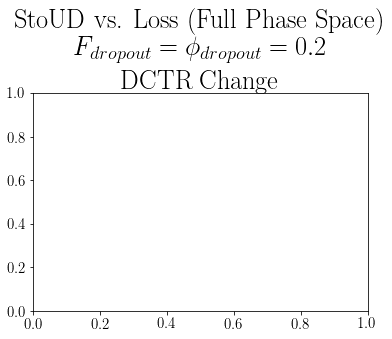

In [16]:
plt.title("StoUD vs. Loss (Full Phase Space)\n $F_{dropout} = \phi_{dropout} = 0.2$\nDCTR Change")
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.vlines(0.200, ymin=np.min(lvals), ymax=np.max(lvals), label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.savefig("probStoUD(200) Vs Loss-FDropoutPhiDropout02-Copy5.png", bbox_inches = "tight")
plt.show()

In [ ]:
thetas[np.argmax(vlvals)]

# Tuning with Gradient Descent

In [17]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    ". theta fit = ", model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [18]:
PFN_model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

batch_size = int(len(X_train_theta) / 10)
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

def my_loss_wrapper_fit(inputs,mysign = 1, MSE_loss=False):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    
    if mysign == 1:
        # regular batch size
        x = K.gather(x, np.arange(1000))
        #  when not training theta, fetch as np array
        theta0 = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array
    else:
        # special theta batch size
        x = K.gather(x, np.arange(batch_size))
        # when training theta, fetch as tf.Variable
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable

    weights = reweight(events = x, param = theta0) # NN reweight
    
    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        else:
            # Categorical Cross-Entropy Loss
            #Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        return K.mean(t_loss)
    return my_loss

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              
__________________________________________________________________________________________________
activation

In [19]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=1000,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_train_theta, Y_train_theta, epochs=1, batch_size=batch_size,verbose=1,callbacks=callbacks)    
    pass

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    #     print("index_refine", index_refine)
    #     print("extrema", extrema)

    #     if (len(extrema) == 0
    #         ):  # If none are found, keep fitting (catching index error)
    #         pass
    if (len(extrema) >= 6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 151s 167us/step - loss: 0.5987 - acc: 0.4972 - val_loss: 0.5872 - val_acc: 0.4956
. theta fit =  0.0
Training theta
Epoch 1/1
1800000/1800000 [==============================] - 225s 125us/step - loss: nan - acc: 0.4957         
. theta fit =  nan


NameError: name 'argrelmin' is not defined

In [ ]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.200, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("probStuUD (start = 0.12) \nN = {:.0e}, learning_rate = {:.0e}".format(len(X_default), lr))
plt.savefig("probStuUD Fit \nN = {:.0e}, learning_rate = {:.0e}.png".format(len(X_default), 5e-7))
plt.show()
